## Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.  
  
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.  
  
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.  

● city: city this user signed up in  
● phone: primary device for this user  
● signup_date: date of account registration; in the form ‘YYYYMMDD’  
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’  
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup  
● avg_rating_by_driver: the rider’s average rating over all of their trips  
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips  
● surge_pct: the percent of trips taken with surge multiplier > 1  
● avg_surge: The average surge multiplier over all of this user’s trips  
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up  
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE  
otherwise  
● weekday_pct: the percent of the user’s trips occurring during a weekday  
  
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?  

In [200]:
import pandas as pd
import numpy as np
import json

from datetime import datetime
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay

In [201]:
# Load & look

with open('../data/raw/ultimate_data_challenge.json', 'rb') as file :
    raw_data = json.load(file)

raw_data[0]

{'city': "King's Landing",
 'trips_in_first_30_days': 4,
 'signup_date': '2014-01-25',
 'avg_rating_of_driver': 4.7,
 'avg_surge': 1.1,
 'last_trip_date': '2014-06-17',
 'phone': 'iPhone',
 'surge_pct': 15.4,
 'ultimate_black_user': True,
 'weekday_pct': 46.2,
 'avg_dist': 3.67,
 'avg_rating_by_driver': 5.0}

In [202]:
# Frame it

data = pd.DataFrame(raw_data)
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [203]:
# Check it

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [204]:
# Before we go any farther, let's find our retention rate.

data['retained'] = data['last_trip_date'] >= '2014-06-01'
data['retained'] = data['retained'].astype(int)
retention_rate = data['retained'].sum() / len(data)
print(f"Retained: {data['retained'].value_counts()[0]}")
print(f"Churned: {data['retained'].value_counts()[1]}")
print(f"Retention rate: {retention_rate}")

Retained: 31196
Churned: 18804
Retention rate: 0.37608


In [205]:
# Remove nulls from cols with acceptably few nulls

data = data[~data['phone'].isnull()]
data = data[~data['avg_rating_by_driver'].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49406 non-null  object 
 1   trips_in_first_30_days  49406 non-null  int64  
 2   signup_date             49406 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               49406 non-null  float64
 5   last_trip_date          49406 non-null  object 
 6   phone                   49406 non-null  object 
 7   surge_pct               49406 non-null  float64
 8   ultimate_black_user     49406 non-null  bool   
 9   weekday_pct             49406 non-null  float64
 10  avg_dist                49406 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
 12  retained                49406 non-null  int32  
dtypes: bool(1), float64(6), int32(1), int64(1), object(4)
memory usage: 4.8+ MB


In [206]:
# Standardize our bool col

data['ultimate_black_user'] = data['ultimate_black_user'].astype(int)

In [207]:
# It's always time for datetime

data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

In [208]:
# What's our target, then?

max(data['last_trip_date'])

Timestamp('2014-07-01 00:00:00')

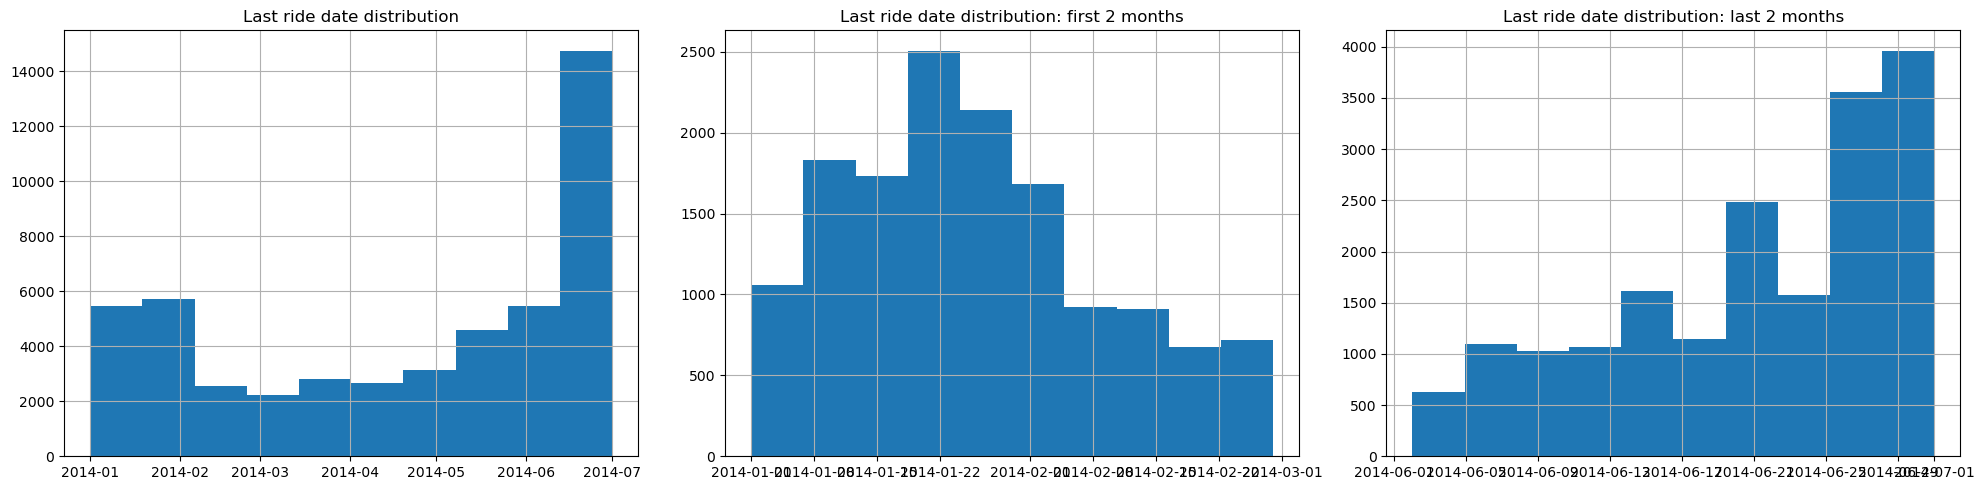

In [209]:
# Based on the following plots, I've decided that the last ride dates
# are probably free of serious errors.

fig, ax = plt.subplots(1, 3, figsize=[20,5])

data['last_trip_date'].hist(ax=ax[0])
ax[0].set_title("Last ride date distribution")

data[data['last_trip_date'] < '2014-03-01']['last_trip_date'].hist(ax=ax[1])
ax[1].set_title("Last ride date distribution: first 2 months")

data[data['last_trip_date'] > '2014-06-01']['last_trip_date'].hist(ax=ax[2])
ax[2].set_title("Last ride date distribution: last 2 months")

plt.tight_layout()
plt.show()

In [210]:
# Let's make a fun ratio!
# If retention is random, or if a variable does not have a correlation to retention,
# this should be the ratio we see between retained and not retained counts.

retention_ratio = data['retained'].value_counts()[0] / data['retained'].value_counts()[1]
retention_ratio

1.651247652267239

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7961 entries, 6 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    7961 non-null   object        
 1   trips_in_first_30_days  7961 non-null   int64         
 2   signup_date             7961 non-null   datetime64[ns]
 3   avg_rating_of_driver    0 non-null      float64       
 4   avg_surge               7961 non-null   float64       
 5   last_trip_date          7961 non-null   datetime64[ns]
 6   phone                   7961 non-null   object        
 7   surge_pct               7961 non-null   float64       
 8   ultimate_black_user     7961 non-null   int32         
 9   weekday_pct             7961 non-null   float64       
 10  avg_dist                7961 non-null   float64       
 11  avg_rating_by_driver    7961 non-null   float64       
 12  retained                7961 non-null   int32  

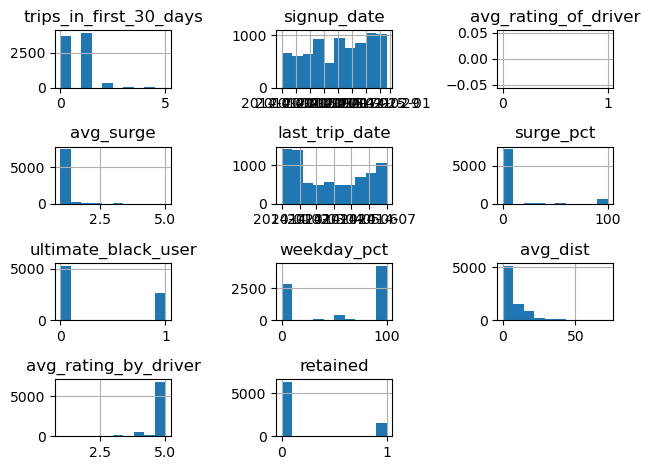

In [211]:
# Only one column has significant remaining nulls.
# Let's look at the rows with nulls in those cols and see if there are any
# obvious trends.

no_rating_of_driver = data[data['avg_rating_of_driver'].isnull()]
print(no_rating_of_driver.info())
no_rating_of_driver.hist()
plt.tight_layout()
plt.show()

In [212]:
# The variable has a clear mode, but the null rows' retention ratio is very
# different from the retention ratio for drivers with the mode & mean values.
# Thus, lumping missing values into the mode or mean would remove trends in our data.

# Let's find out which avg rating displays a retention ratio most similar to the ratio
# of drivers with missing review info, then lump the null rows into that value.
print(f"The avg retention for drivers with null ratings of driver is {no_rating_of_driver['retained'].mean()}\n")

display_data = data[['avg_rating_of_driver', 'retained']]
display_data['count'] = 1
display_data = display_data.groupby('avg_rating_of_driver').agg({'retained':'mean', 'count':'sum'})

print("The avg retention of rated drivers by rating score are:")
print(display_data)

The avg retention for drivers with null ratings of driver is 0.20097977640999876

The avg retention of rated drivers by rating score are:
                      retained  count
avg_rating_of_driver                 
1.0                   0.179283    251
1.5                   0.250000      4
1.6                   1.000000      1
1.7                   0.000000      2
1.8                   0.000000      2
1.9                   1.000000      1
2.0                   0.206897    203
2.1                   0.833333      6
2.2                   1.000000      1
2.3                   0.363636     22
2.4                   0.666667      3
2.5                   0.397849     93
2.6                   0.333333     12
2.7                   0.468085     47
2.8                   0.500000     28
2.9                   0.692308     13
3.0                   0.265990    985
3.1                   0.763158     38
3.2                   0.754717     53
3.3                   0.490000    200
3.4                   0.61

C:\Users\Josh\AppData\Local\Temp\ipykernel_30156\361953643.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display_data['count'] = 1


In [213]:
# The retained ratio for drivers with no ratings most resembles a rating of 2.0,
# but there aren't very many drivers with that rating. Lumping all the nulls into
# that rating could imbalance the data.
# Instead, since the retention ratio is fairly low, let's invent a new rating
# to hold the values: 5.1

for index, row in data.iterrows() :
    if math.isnan(row['avg_rating_of_driver']) :
        data.loc[index, 'avg_rating_of_driver'] = 5.1

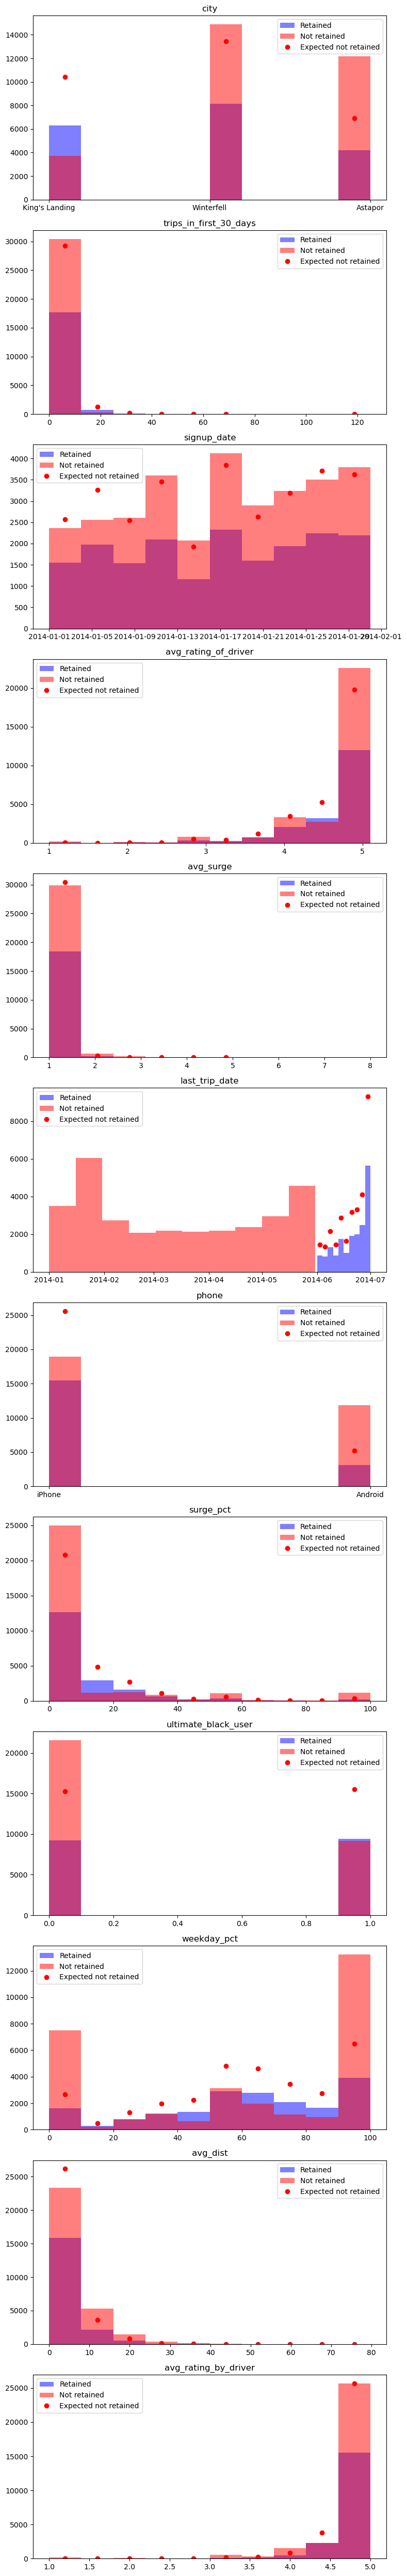

In [214]:
# Look at pretty charts

retained = data[data['retained'] == 1]
not_retained = data[data['retained'] == 0]

fig, ax = plt.subplots(12, 1, figsize=[8, 50])
flax = ax.flatten()
counter = 0

for i in range(len(flax)) :
    col = retained.columns[i]

    # To standardize our bin widths, we have to look at the data as a whole.
    bin_range = (min(min(retained[col]), min(not_retained[col])), \
                    max(max(retained[col]), max(not_retained[col])))


    # In order to standardize our bin widths, we have to split our numerics from our cats.
    if type(bin_range[0]) == int or type(bin_range[0]) == float and not math.isnan(bin_range[0]):
        hist, bins, _ = flax[i].hist(retained[col], color='blue', alpha=0.5, label='Retained', \
                                     range=bin_range, bins=10)
        flax[i].hist(not_retained[col], color='red', alpha=0.5, label='Not retained', \
                    range=bin_range, bins=10)
    else :
        hist, bins, _ = flax[i].hist(retained[col], color='blue', alpha=0.5, label='Retained')
        flax[i].hist(not_retained[col], color='red', alpha=0.5, label='Not retained')

    # Now we do some fancy stuff to put a red dot at the spot we would expect the
    # non-retention line to reach, if this feature is not correlated to the variable.
    bin_diff = (bins[1] - bins[0])/2
    bin_centers = [bin + bin_diff for bin in bins]
    bin_centers.pop(-1)
    heights = [height*retention_ratio for height in hist]
    # Since the cat features have a lot of 0 bins, we mask & remove them.
    # This requires arrays.
    heights = np.array(heights)
    bin_centers = np.array(bin_centers)
    mask = heights != 0
    bin_centers = bin_centers[mask]
    heights = heights[mask]
    # Now we plug it in.
    flax[i].plot(bin_centers, heights, 'ro', label='Expected not retained')
  
    flax[i].set_title(f'{col}')
    flax[i].legend()

plt.tight_layout()
plt.show()

From the above, we can deduce the following:  

1. City, phone, ultimate_black_user, and weekday_pct have strong correlations to the label.

2. avg_rating_of_driver, avg_rating_by_driver, and surg_pct appear to have mild correlations to the label.

3. trips_in_first_thirty_days, avg_surge, avg_first do not appear to be useful.

4. signup_date, last_trip_date are simply unuseful for our purposes.

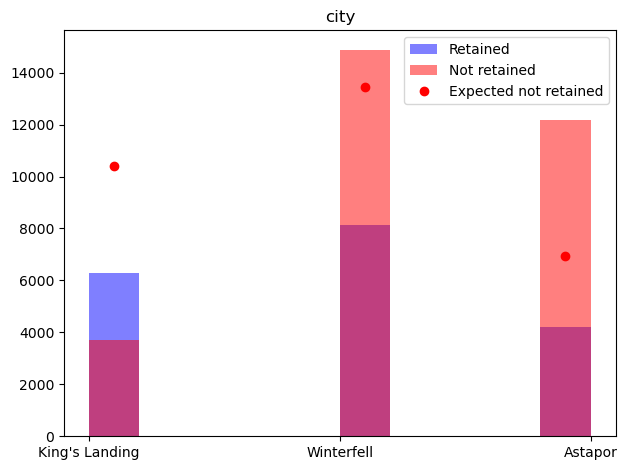

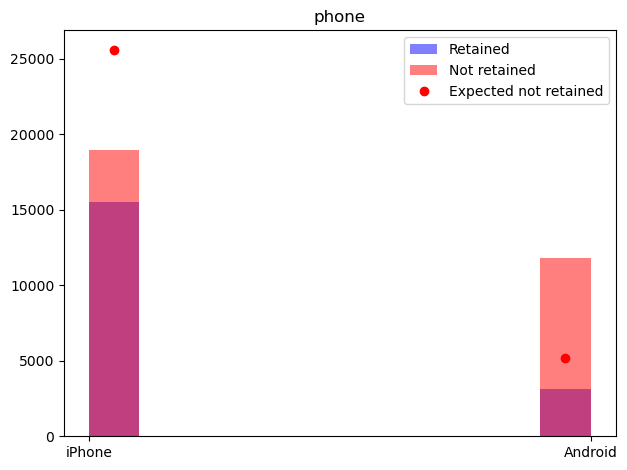

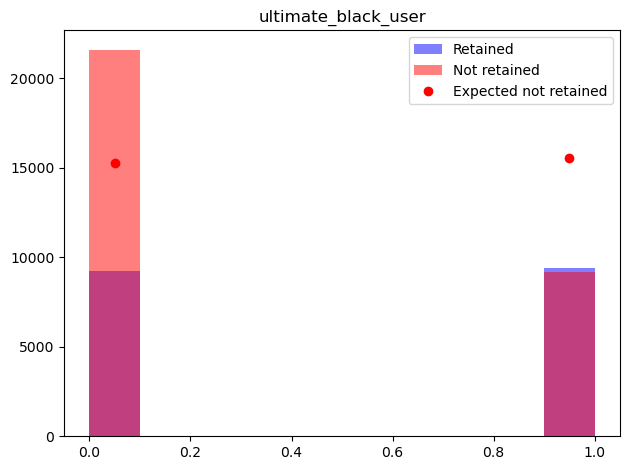

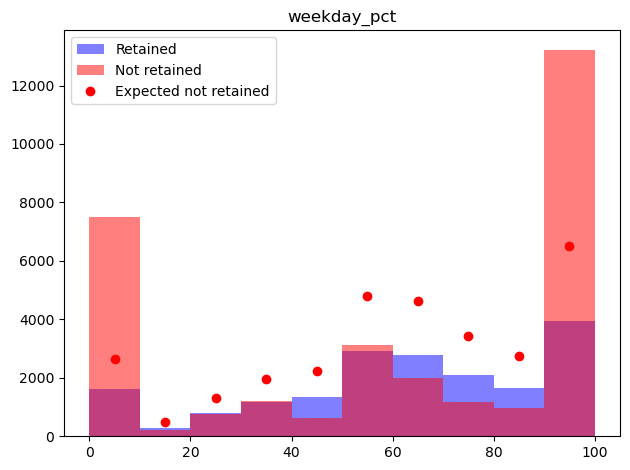

In [215]:
# I'll use this cell to churn out the charts I need.

cols = ['city', 'phone', 'ultimate_black_user', 'weekday_pct']

for col in cols :

    fig, ax = plt.subplots()

    bin_range = (min(min(retained[col]), min(not_retained[col])), \
                    max(max(retained[col]), max(not_retained[col])))

    if type(bin_range[0]) == int or type(bin_range[0]) == float and not math.isnan(bin_range[0]):
        hist, bins, _ = ax.hist(retained[col], color='blue', alpha=0.5, label='Retained', \
                                        range=bin_range, bins=10)
        ax.hist(not_retained[col], color='red', alpha=0.5, label='Not retained', \
                    range=bin_range, bins=10)
    else :
        hist, bins, _ = ax.hist(retained[col], color='blue', alpha=0.5, label='Retained')
        ax.hist(not_retained[col], color='red', alpha=0.5, label='Not retained')

    # Now we do some fancy stuff to put a red dot at the spot we would expect the
    # non-retention line to reach, if this feature is not correlated to the variable.
    bin_diff = (bins[1] - bins[0])/2
    bin_centers = [bin + bin_diff for bin in bins]
    bin_centers.pop(-1)
    heights = [height*retention_ratio for height in hist]
    # Since the cat features have a lot of 0 bins, we mask & remove them.
    # This requires arrays.
    heights = np.array(heights)
    bin_centers = np.array(bin_centers)
    mask = heights != 0
    bin_centers = bin_centers[mask]
    heights = heights[mask]
    # Now we plug it in.
    ax.plot(bin_centers, heights, 'ro', label='Expected not retained')

    ax.set_title(f'{col}')
    ax.legend()
    plt.tight_layout()

    plt.savefig(f'../reports/figures/{col}_hist')
    plt.show()

-----------------

2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.  

In [216]:
# Let's begin by removing the unnecessary features.
# Since the rating columns have many nulls, let's ignore them for now
# and incorporate them if we need to later.

useful_cols = ['city', 'phone', 'ultimate_black_user', 'weekday_pct', 'surge_pct', \
               'avg_rating_of_driver', 'avg_rating_by_driver', 'retained']
model_df = data[useful_cols]
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  49406 non-null  object 
 1   phone                 49406 non-null  object 
 2   ultimate_black_user   49406 non-null  int32  
 3   weekday_pct           49406 non-null  float64
 4   surge_pct             49406 non-null  float64
 5   avg_rating_of_driver  49406 non-null  float64
 6   avg_rating_by_driver  49406 non-null  float64
 7   retained              49406 non-null  int32  
dtypes: float64(4), int32(2), object(2)
memory usage: 4.0+ MB


In [217]:
# ALl of these are between 0 and 1 except for the avg ratings. Let's scale them down.

model_df['avg_rating_of_driver'] = MinMaxScaler().fit_transform(model_df['avg_rating_of_driver'].values.reshape(-1,1)).flatten()
model_df['avg_rating_by_driver'] = MinMaxScaler().fit_transform(model_df['avg_rating_by_driver'].values.reshape(-1,1)).flatten()


C:\Users\Josh\AppData\Local\Temp\ipykernel_30156\3328987141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['avg_rating_of_driver'] = MinMaxScaler().fit_transform(model_df['avg_rating_of_driver'].values.reshape(-1,1)).flatten()
C:\Users\Josh\AppData\Local\Temp\ipykernel_30156\3328987141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['avg_rating_by_driver'] = MinMaxScaler().fit_transform(model_df['avg_rating_by_driver'].values.reshape(-1,1)).flatten()


In [218]:
# Let's split features and label

X = model_df[['city', 'phone', 'ultimate_black_user', 'weekday_pct', 'surge_pct', \
               'avg_rating_of_driver', 'avg_rating_by_driver']]

y = model_df['retained']

In [219]:
# Since 'phone' has two values, let's just call it 'iPhone' and make it binary

new_vals = {'iPhone':1, 'Android':0}
X['phone'] = X['phone'].map(new_vals)
X.rename(columns={'phone':'iphone'}, inplace=True)

C:\Users\Josh\AppData\Local\Temp\ipykernel_30156\1396972022.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['phone'] = X['phone'].map(new_vals)
C:\Users\Josh\AppData\Local\Temp\ipykernel_30156\1396972022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={'phone':'iphone'}, inplace=True)


In [220]:
# Since the three cities show a clear hierarchy of retention rates
# we COULD make them a sequential variable. But to keep our theory
# clean, let's one-hot them instead.
# Theoretically we could drop one of the city cols, but there's
# really no reason to worry about that when we have so few cols to
# begin with - and leaving them all in makes our work more
# interpretable.

city_df = pd.get_dummies(X['city'])
X = pd.concat([X, city_df], axis=1)
X.drop(columns=['city'], inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   iphone                49406 non-null  int64  
 1   ultimate_black_user   49406 non-null  int32  
 2   weekday_pct           49406 non-null  float64
 3   surge_pct             49406 non-null  float64
 4   avg_rating_of_driver  49406 non-null  float64
 5   avg_rating_by_driver  49406 non-null  float64
 6   Astapor               49406 non-null  uint8  
 7   King's Landing        49406 non-null  uint8  
 8   Winterfell            49406 non-null  uint8  
dtypes: float64(4), int32(1), int64(1), uint8(3)
memory usage: 3.6 MB


In [221]:
# Now, splits! Since our classes are imbalanced, we should stratify.

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=85,
                                                    stratify=y
                                                    )

Now that our features are all prepped, let's choose our model.  
  
For predicting a binary variable (churn), two immediate options spring to mind: logistic regression and decision trees.  
  
Let's do a logistic regression and an XGBoost.  


In [222]:
# First, logistic regression.
# Since our dataset is small, we can use liblinear.

# Before all that, we'll define a function to run the model and show results.

def show_results(X, y, classifier, metric='accuracy') :

    classifier.fit(X, y)
    y_pred = classifier.predict(X)
    
    model_acc = cross_val_score(classifier, X, y, cv=5, scoring=metric).sum() / 5
    one_class_acc = y.sum() / len(y)
    class_rep = classification_report(y, y_pred)

    print(class_rep)
    print(f'\nCrossval accuracy improvement over guessing ONLY "not_retained": {model_acc - one_class_acc:.2f}')
    print(f'\nF1 score: {f1_score(y, y_pred)}')
    con_mat = confusion_matrix(y, y_pred)
    con_display = ConfusionMatrixDisplay(confusion_matrix=con_mat,
                                        display_labels=['not retained', 'retained'])
    con_display.plot()

              precision    recall  f1-score   support

           0       0.76      0.69      0.72     24616
           1       0.56      0.64      0.60     14908

    accuracy                           0.67     39524
   macro avg       0.66      0.67      0.66     39524
weighted avg       0.68      0.67      0.68     39524


Crossval accuracy improvement over guessing ONLY "not_retained": 0.29

F1 score: 0.5959237097980553


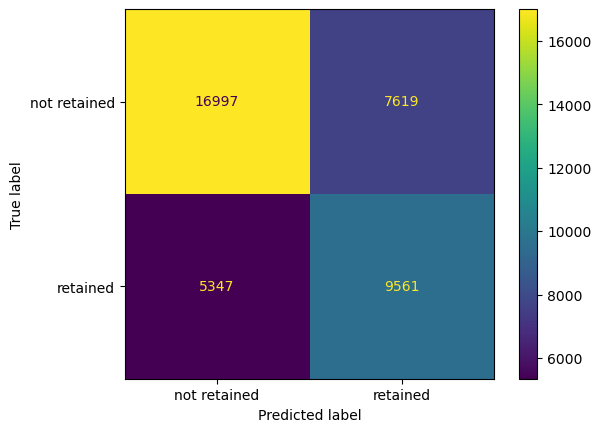

In [223]:
log_classifier = LogisticRegression(solver='liblinear',
                                    max_iter=500,
                                    class_weight='balanced',
                                    random_state=85,
                                    )

show_results(X_train, y_train, log_classifier)

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     24616
           1       0.59      0.60      0.60     14908

    accuracy                           0.69     39524
   macro avg       0.67      0.68      0.68     39524
weighted avg       0.69      0.69      0.69     39524


Crossval accuracy improvement over guessing ONLY "not_retained": 0.32

F1 score: 0.5964185487104102


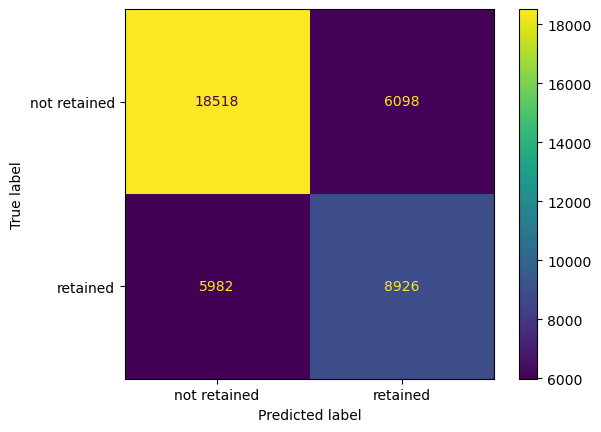

In [224]:
# Looks like our model is "decent" at predicting retained records,
# but incapable of predicting not retained records.
# Let's weight not retained results a bit higher and see if that helps.

weights = {1:1.5, 0:1}
log_classifier = LogisticRegression(solver='liblinear',
                                    max_iter=500,
                                    class_weight=weights,
                                    random_state=85,
                                    )

show_results(X_train, y_train, log_classifier)

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     24616
           1       0.58      0.60      0.59     14908

    accuracy                           0.68     39524
   macro avg       0.66      0.67      0.67     39524
weighted avg       0.69      0.68      0.68     39524


Crossval accuracy improvement over guessing ONLY "not_retained": 0.31

F1 score: 0.587363288970879


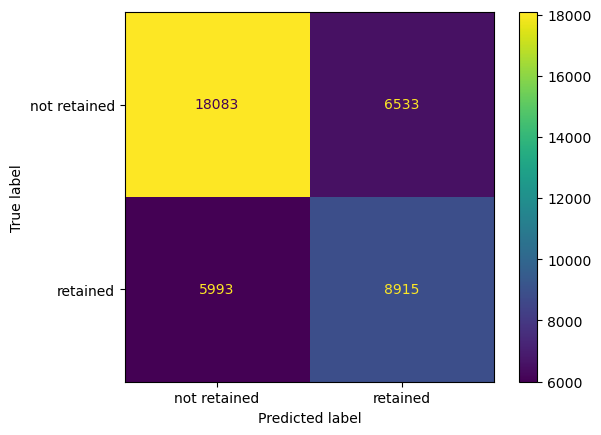

In [225]:
# That didn't help very much. Let's try removing some borderline features and seeing if that helps.

X_new = X[['iphone', 'ultimate_black_user', 'weekday_pct', 'surge_pct',
           'Astapor', 'Winterfell', "King's Landing"]]

Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_new, y,
                                                        test_size=0.2,
                                                        random_state=85,
                                                        stratify=y
                                                        )

weights = {1:1.5, 0:1}
log_classifier = LogisticRegression(solver='liblinear',
                                    max_iter=500,
                                    class_weight=weights,
                                    random_state=85,
                                    )

show_results(Xn_train, yn_train, log_classifier)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83     24616
           1       0.74      0.65      0.69     14908

    accuracy                           0.78     39524
   macro avg       0.77      0.76      0.76     39524
weighted avg       0.78      0.78      0.78     39524


Crossval accuracy improvement over guessing ONLY "not_retained": 0.40

F1 score: 0.6940498765608788


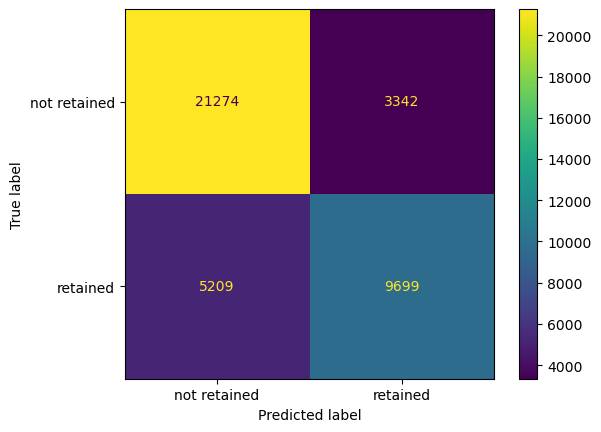

In [226]:
# Still no joy. Let's try XGBoost!

gb_classifier = GradientBoostingClassifier()

show_results(X_train, y_train, gb_classifier)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83     24616
           1       0.74      0.64      0.68     14908

    accuracy                           0.78     39524
   macro avg       0.77      0.75      0.76     39524
weighted avg       0.77      0.78      0.77     39524


Crossval accuracy improvement over guessing ONLY "not_retained": 0.40

F1 score: 0.6832996827228152


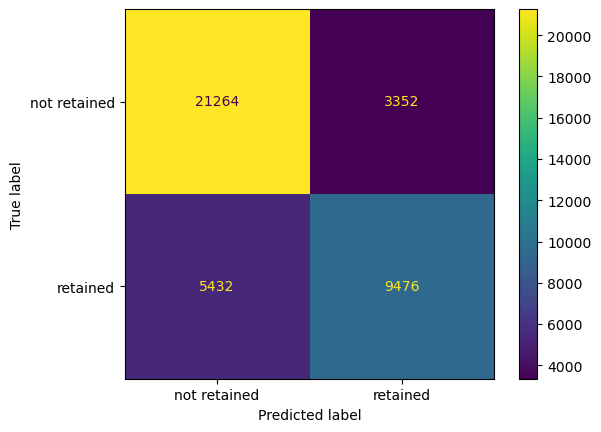

In [227]:
# Right off the bat we're miles ahead! Let's try that with our reduced dataset and see what's up.

show_results(Xn_train, yn_train, gb_classifier)

Winning hp: {'subsample': 0.75, 'n_estimators': 50, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 1, 'max_depth': 5, 'learning_rate': 0.1}
Highest score: 0.6869300133861167
              precision    recall  f1-score   support

           0       0.80      0.87      0.83     24616
           1       0.75      0.64      0.69     14908

    accuracy                           0.78     39524
   macro avg       0.77      0.76      0.76     39524
weighted avg       0.78      0.78      0.78     39524


Crossval accuracy improvement over guessing ONLY "not_retained": 0.40

F1 score: 0.6908487776736136


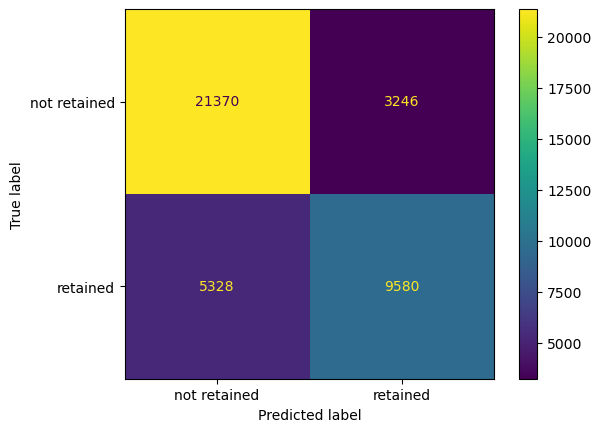

In [228]:
# Slightly worse! Who knew!
# Since this is our best model so far, let's do some hyperparameter tuning.

params = {
    'n_estimators':[50],
    'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth':[3, 5, 7, 9, 10],
    'min_samples_split':[2, 5, 8, 11, 14, 17, 20],
    'min_samples_leaf':[1, 4, 7, 10],
    'subsample':[0.5, 0.75, 1],
    'max_features':[0.5, 0.75, 1]
}

tuned_gb_classifier = RandomizedSearchCV(GradientBoostingClassifier(),
                                         scoring=make_scorer(f1_score),
                                         param_distributions=params,
                                         n_iter=10,
                                         cv=5,
                                         random_state=85)

tuned_gb_classifier.fit(X, y)

print(f'Winning hp: {tuned_gb_classifier.best_params_}')
print(f'Highest score: {tuned_gb_classifier.best_score_}')

winning_model = tuned_gb_classifier.best_estimator_
show_results(X_train, y_train, winning_model)

Winning hp: {'subsample': 0.6, 'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 1, 'max_depth': 6, 'learning_rate': 0.2}
Highest score: 0.6883221394744605
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     24616
           1       0.75      0.66      0.70     14908

    accuracy                           0.79     39524
   macro avg       0.78      0.76      0.77     39524
weighted avg       0.79      0.79      0.79     39524


Crossval accuracy improvement over guessing ONLY "not_retained": 0.40

F1 score: 0.7038097966198797


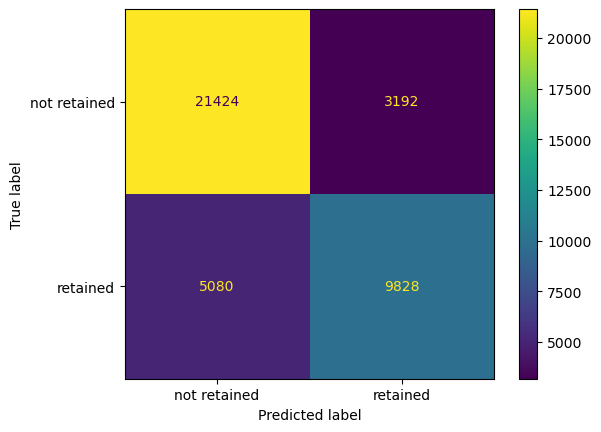

In [229]:
# Let's zero in a bit on the optimal parameter ranges.

params = {
    'n_estimators':[50],
    'learning_rate':[1.8, 1.9, 0.2, 0.21, 0.22],
    'max_depth':[6, 7, 8],
    'min_samples_split':[3, 4, 5, 6],
    'min_samples_leaf':[1, 2, 3],
    'subsample':[0.3, 0.4, 0.5, 0.6],
    'max_features':[0.8, 0.9, 1]
}

tuned_gb_classifier = RandomizedSearchCV(GradientBoostingClassifier(),
                                         scoring=make_scorer(f1_score),
                                         param_distributions=params,
                                         n_iter=20,
                                         cv=5,
                                         random_state=85)

tuned_gb_classifier.fit(X, y)

print(f'Winning hp: {tuned_gb_classifier.best_params_}')
print(f'Highest score: {tuned_gb_classifier.best_score_}')

winning_model = tuned_gb_classifier.best_estimator_

show_results(X_train, y_train, winning_model)

In [243]:
# This might be the best model we can get, so let's identify our feature importances.

importances = winning_model.feature_importances_
imps = pd.Series()
cols = X.columns
for i in range(len(importances)) :
    imps[cols[i]] = importances[i]

imps = imps.sort_values(ascending=False)
imps


C:\Users\Josh\AppData\Local\Temp\ipykernel_30156\4000368513.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  imps = pd.Series()


weekday_pct             0.195119
avg_rating_by_driver    0.157908
avg_rating_of_driver    0.153001
surge_pct               0.131565
King's Landing          0.115356
iphone                  0.093214
ultimate_black_user     0.087234
Astapor                 0.040728
Winterfell              0.025874
dtype: float64

In [231]:
# Let's un-scale the ratings to make this part more legible.

scaling_ratio_1 = 4 / (max(X['avg_rating_by_driver']) - min(X['avg_rating_by_driver']))
scaling_ratio_2 = 4.1 / (max(X['avg_rating_of_driver']) - min(X['avg_rating_of_driver']))

X['avg_rating_by_driver'] = (X['avg_rating_by_driver'] * scaling_ratio_1) + 1
X['avg_rating_of_driver'] = (X['avg_rating_of_driver'] * scaling_ratio_2) + 1

In [232]:
# Now that we know which features are most important, let's identify the critical range for those
# features, giving Ultimate something to look for.
grouped_dfs = []
merged_dfs = pd.concat([X, y], axis=1)
merged_dfs['count'] = 1
for col in cols :
    grouped_dfs.append(merged_dfs[[col, 'retained', 'count']].groupby(by=col,).agg({'retained':'mean', 'count':'sum'}))

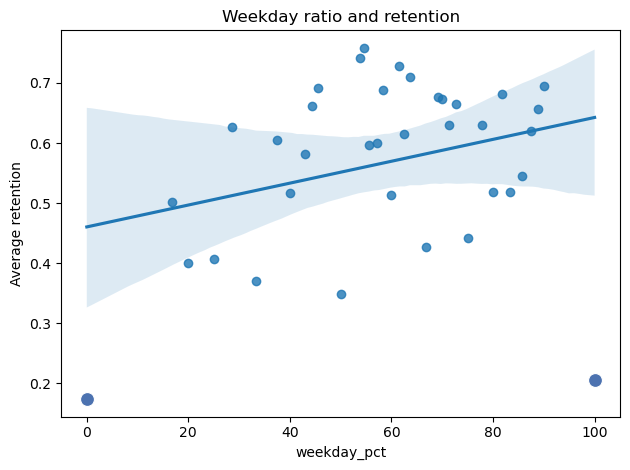

In [244]:
sns.regplot(x=relevant_weekday_rows.index, y=relevant_weekday_rows['retained'])
lowest = relevant_weekday_rows.loc[0]['retained']
highest = relevant_weekday_rows.loc[100]['retained']
sns.scatterplot(x=[0, 100], y=[lowest, highest], color=sns.color_palette("deep")[0], s=100)
plt.title("Weekday ratio and retention")
plt.ylabel('Average retention')
plt.tight_layout()
plt.savefig('../reports/figures/weekday_vs_retention')

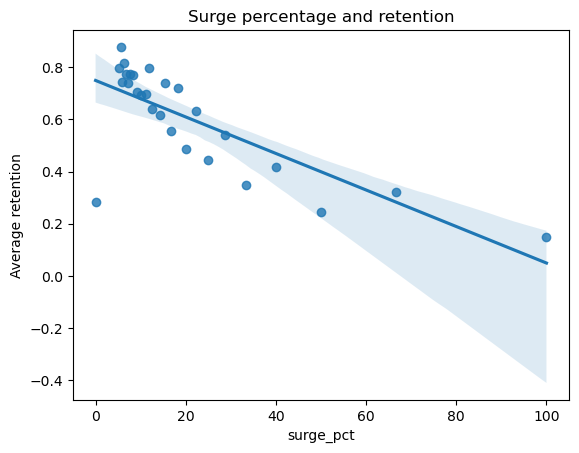

In [233]:
relevant_surge_rows = grouped_dfs[3][grouped_dfs[3]['count'] > 100]

sns.regplot(x=relevant_surge_rows.index, y=relevant_surge_rows['retained'])
plt.title("Surge percentage and retention")
plt.ylabel('Average retention')
plt.savefig('../reports/figures/surge_vs_retention')

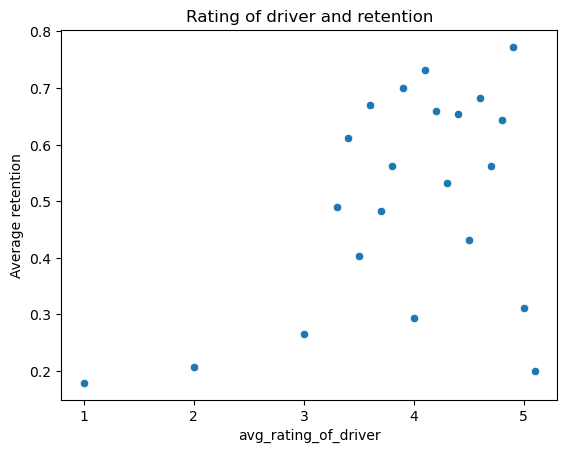

In [264]:
relevant_of_driver_rows = grouped_dfs[4][grouped_dfs[4]['count'] > 100]

sns.scatterplot(x=relevant_of_driver_rows.index, y=relevant_of_driver_rows['retained'])
plt.title('Rating of driver and retention')
plt.ylabel('Average retention')
plt.savefig('../reports/figures/of_driver_vs_retention')

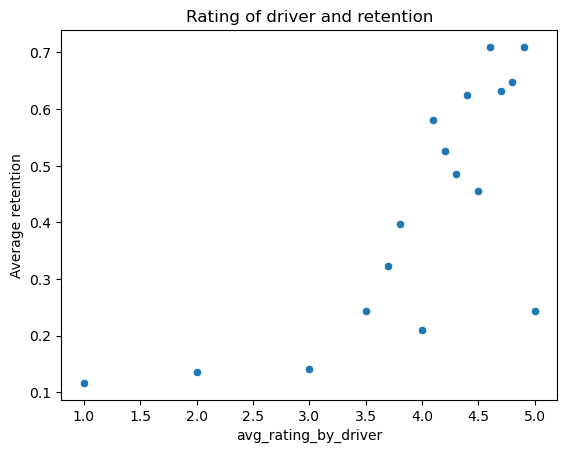

In [263]:
relevant_by_driver_rows = grouped_dfs[5][grouped_dfs[5]['count'] > 100]

sns.scatterplot(x=relevant_by_driver_rows.index, y=relevant_by_driver_rows['retained'])
plt.title('Rating of driver and retention')
plt.ylabel('Average retention')
plt.savefig('../reports/figures/by_driver_vs_retention')

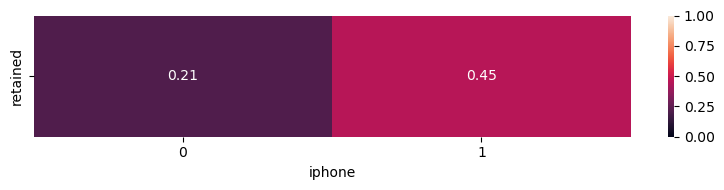

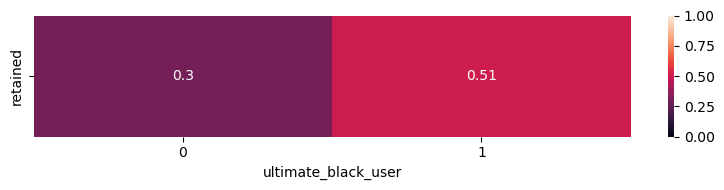

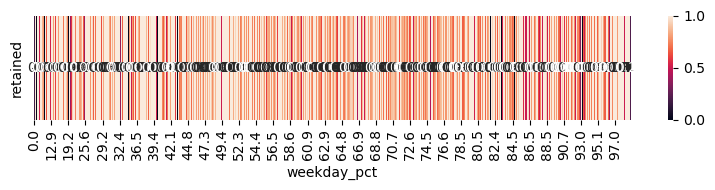

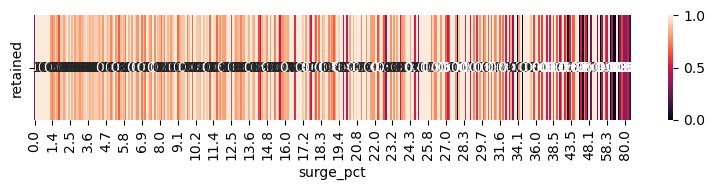

C:\Users\Josh\AppData\Local\Temp\ipykernel_30156\936747686.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


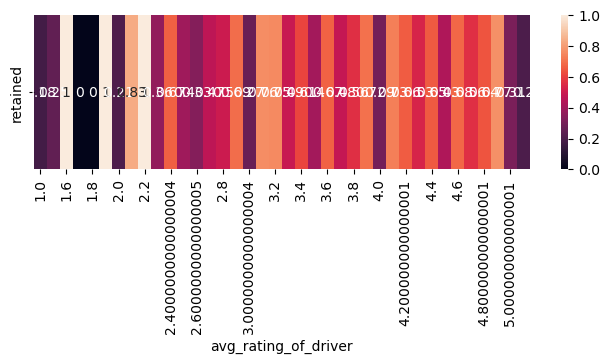

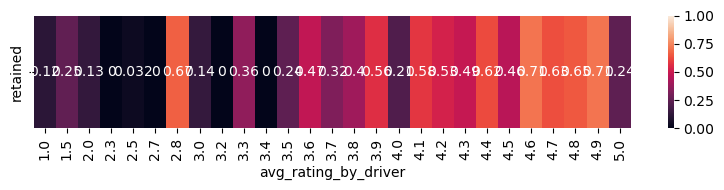

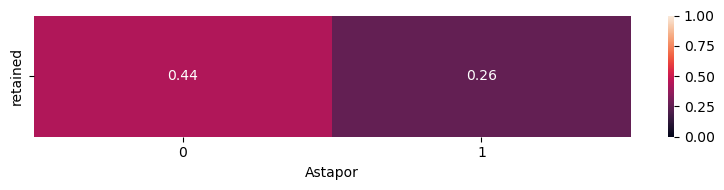

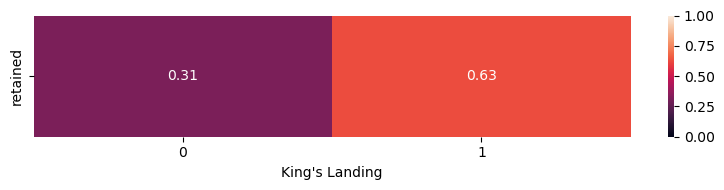

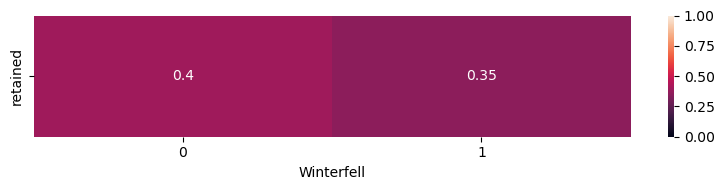

In [235]:
for i in range(len(grouped_dfs)) :
    df = pd.DataFrame(grouped_dfs[i]['retained'])
    plt.figure(figsize=(8, 2))
    sns.heatmap(df.T, vmin=0, vmax=1, annot=True)
    plt.tight_layout()
    plt.show()

<Axes: >

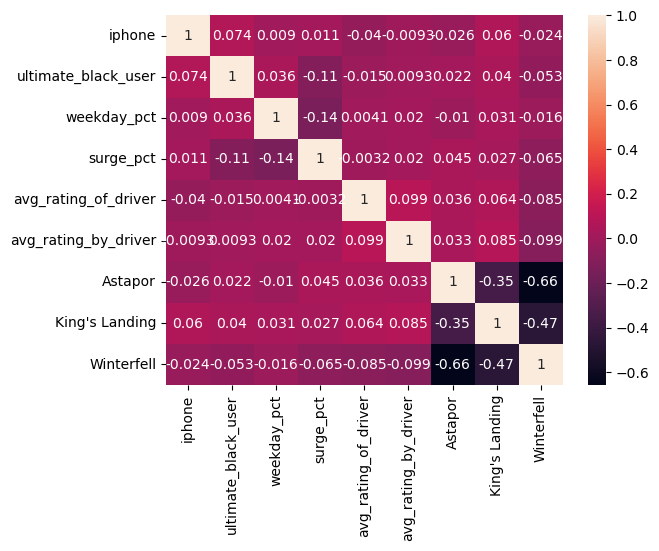

In [236]:
# Now let's check our correlations between these key variables.
# Looks like there aren't any significant correlations! Great.

sns.heatmap(X.corr(), annot=True)

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

1. The Ultimate Black program does seem to correlate to higher retention.

2. The largest influence on retention (accounting for almost 20% of the variance) is the weekday percentage. Drivers who drive exclusively on weekdays or exclusively on weekends tend to drop out. Drivers who drive more on weekdays tend to have slightly higher retention, until it hits 100% at which point it plummets. 

3. Oddly, drivers who give and receive whole-number average ratings tend to have much worse retention. Retention is much better when average ratings are between whole numbers. 

4. King's Landing is less likely to lose drivers. Researching conditions in King's Landing could yield insights.

5. iPhone use, surprisingly, is a big indicator of retention. This could indicate that the Android experience is less optimal, but more investigation is warranted.